In [18]:
from pharynx_redox import (
    pharynx_io as pio, 
    image_processing as ip, 
    experiment, 
    plots, 
    profile_processing,
    data_analysis as da,
    utils
)

import xarray as xr
from pathlib import Path
from tqdm import tqdm_notebook
import seaborn as sns
from importlib import reload
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import skfda
from skfda.representation import FDataGrid, FDataBasis
from scipy import ndimage as ndi
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)
reload(da)
reload(utils)

pd.set_option('display.max_rows', 100)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [2]:
params = dict(
    experiment_dir="/Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/",
    imaging_scheme="TL/470/410/470/410",
    should_register=False
)

ex_unreg = experiment.PairExperiment(**params).full_pipeline()

04:36:12 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
04:36:12 INFO:Loading Images
04:36:13 INFO:Segmenting pharynxes
04:36:15 INFO:Centering and rotating pharynxes


04:36:24 INFO:Calculating midlines


04:36:26 INFO:Measuring under midlines


04:36:27 INFO:Trimming intensity data


04:36:28 INFO:Calculating redox measurements
04:36:28 INFO:Saving 2017_02_22-HD233_SAY47 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
04:36:28 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-summary_table.csv
04:36:29 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-10_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-profile_data.nc
04:36:29 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47


In [3]:
i410_0 = x_unreg.untrimmed_profiles.sel(wavelength='410', pair=0)
i470_0 = ex_unreg.untrimmed_profiles.sel(wavelength='470', pair=0)
i410_1 = ex_unreg.untrimmed_profiles.sel(wavelength='410', pair=1)
i470_1 = ex_unreg.untrimmed_profiles.sel(wavelength='470', pair=1)

In [21]:
basis = skfda.representation.basis.BSpline(nbasis=64)-
smoother = skfda.preprocessing.smoothing.BasisSmoother(basis, method='cholesky')

f410_0 = smoother.fit_transform(FDataGrid(i410_0))
f470_0 = smoother.fit_transform(FDataGrid(i470_0))
f410_1 = smoother.fit_transform(FDataGrid(i410_1))
f470_1 = smoother.fit_transform(FDataGrid(i470_1))

In [40]:
template = f410_0.mean()

lam = 0

r410_0 = skfda.preprocessing.registration.elastic_registration(f410_0, template, lam=lam)
r470_0 = skfda.preprocessing.registration.elastic_registration(f470_0, template, lam=lam)
r410_1 = skfda.preprocessing.registration.elastic_registration(f410_1, template, lam=lam)
r470_1 = skfda.preprocessing.registration.elastic_registration(f470_1, template, lam=lam)

In [41]:
r470_0 = skfda.preprocessing.registration.elastic_registration(r470_0, r410_0, lam=lam)
r470_1 = skfda.preprocessing.registration.elastic_registration(r470_1, r410_1, lam=lam)

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x12ccfff98>])

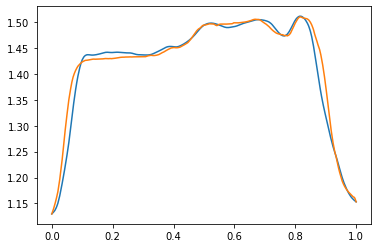

In [42]:
(f410_0 / f470_0).mean().plot()
(r410_0 / r470_0).mean().plot()

In [43]:
rr_raw = np.squeeze(((f410_0 / f470_0) / (f410_1 / f470_1)).data_matrix)
rr_reg = np.squeeze(((r410_0 / r470_0) / (r410_1 / r470_1)).data_matrix)

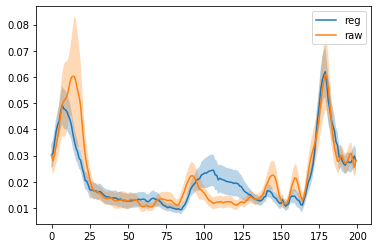

In [44]:
ax = plots.plot_profile_avg_with_bounds(np.abs(1 - rr_reg), label='reg');
plots.plot_profile_avg_with_bounds(np.abs(1 - rr_raw), ax=ax, label='raw');
ax.legend()